### Simple 2D exampling of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from diffusion import (
    get_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_2d,
)
from util import (
    get_torch_size_string,
    plot_ddpm_2d_result,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.3.1+cu118].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
device = 'cuda' if th.cuda.is_available() else 'mps'
print ("device:[%s]"%(device))

device:[cuda]


### Training data `x_0`: [N x C x W x H]

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
x_0 = train_data[:,None,:,:].to(device)/255.
print ("MNIST ready. train_data:[%s]"%(get_torch_size_string(x_0)))

MNIST ready. train_data:[60000x1x28x28]


In [4]:
print(train_label[59999])

tensor(8)


### Embeddings

In [5]:
import torch
import torch.nn as nn

# 임베딩 차원 설정 (예: 8차원 임베딩 벡터)
embedding_dim = 8

# circle 임베딩
circle_embedding = nn.Embedding(2, embedding_dim).to(device)
number_embedding = nn.Embedding(10, embedding_dim).to(device)
# glasses_embedding = nn.Embedding(2, embedding_dim)

# 가중치 초기화 (선택 사항)
# nn.init.xavier_uniform_(circle_embedding.weight)
# nn.init.xavier_uniform_(glasses_embedding.weight)

In [6]:
def get_conditioning_embedding(number, device):
    circle_label = 0
    if number == 0 or number == 6 or number == 8 or number == 9:
        circle_label = 1
    # 레이블을 텐서로 변환
    circle_label = torch.tensor(circle_label, dtype=torch.long).to(device)
    number_label = torch.tensor(number, dtype=torch.long).to(device)
    # 임베딩 벡터 생성
    circle_embed = circle_embedding(circle_label)
    number_embed = number_embedding(number_label)


    # 두 임베딩 벡터를 결합
    conditioning_embedding = torch.cat([circle_embed, number_embed], dim=-1)
    
    return conditioning_embedding

test_number = 7
embedding_vector = get_conditioning_embedding(test_number, device)
print(embedding_vector)

embedding_vectors = torch.stack([get_conditioning_embedding(label.item(),device) for label in train_label])

# test_labels = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
# test_embedding_vectors = torch.stack([get_conditioning_embedding(label,device) for label in test_labels])

test_embedding_vector = get_conditioning_embedding(0,device)

tensor([ 0.893,  0.427, -0.611, -1.098, -0.577,  1.913,  0.144, -0.603,  0.871,
         0.865,  2.465, -0.082, -0.378,  0.094, -0.149,  0.345],
       device='cuda:0', grad_fn=<CatBackward0>)


In [7]:
print(train_label[-10:])
print(embedding_vectors[59995])
print(embedding_vectors[59999])

tensor([9, 2, 9, 5, 1, 8, 3, 5, 6, 8])
tensor([ 1.449, -0.784,  0.580, -1.143,  0.823,  0.153,  0.267,  1.131,  1.046,
        -0.233, -0.935,  1.376, -1.842, -0.300,  1.058, -0.265],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 1.449, -0.784,  0.580, -1.143,  0.823,  0.153,  0.267,  1.131,  1.046,
        -0.233, -0.935,  1.376, -1.842, -0.300,  1.058, -0.265],
       device='cuda:0', grad_fn=<SelectBackward0>)


### Train 

it:[      0][0.0]% loss:[0.6512]


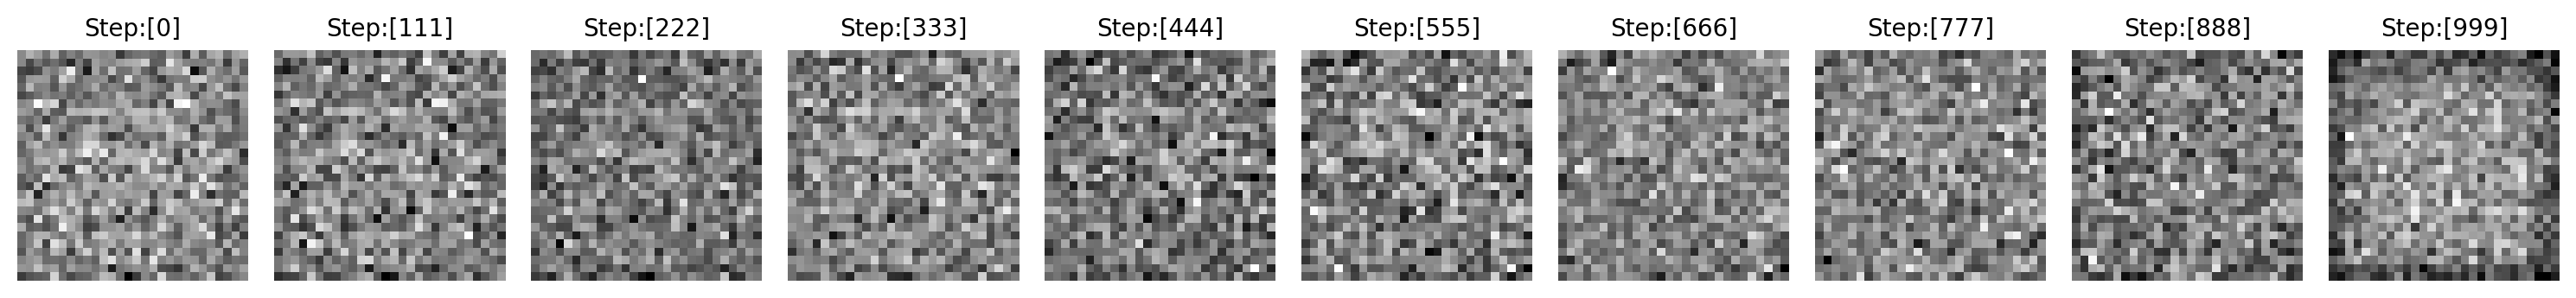

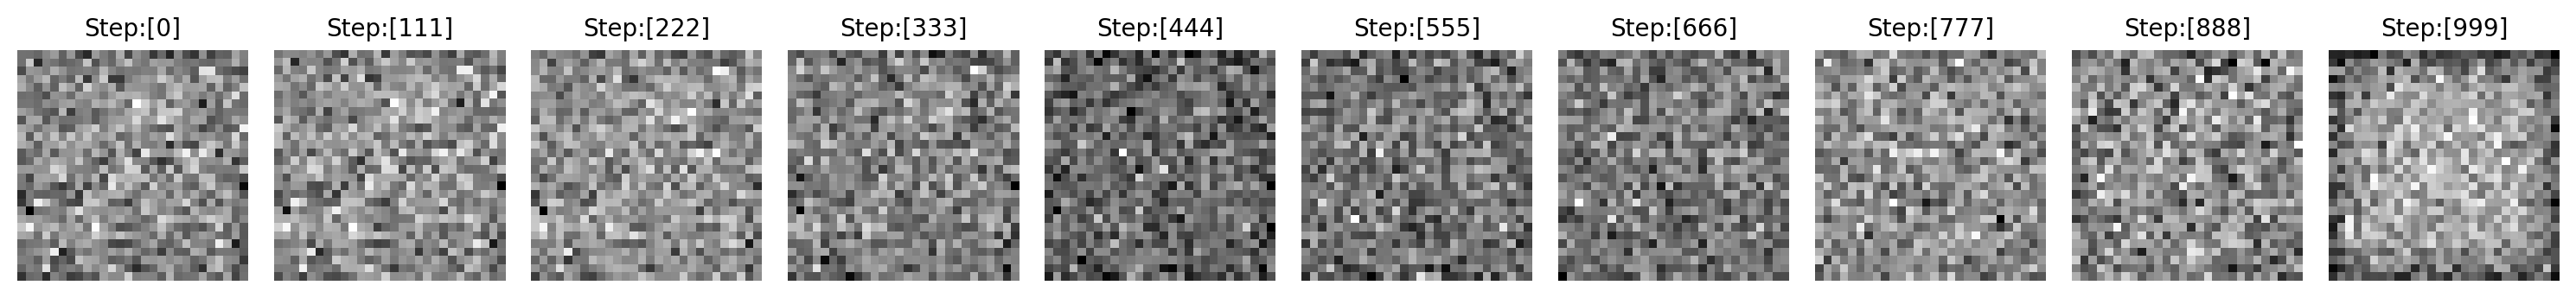

In [9]:
# Instantiate U-net
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 2,
    n_in_channels        = 1,
    n_base_channels      = 64,
    n_emb_dim            = 128,
    n_cond_dim           = embedding_dim * 2,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False, # no attention for images
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,1,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x W x H] => output:[B x C x W x H]

# Configuration
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x W x H]
    # Noise prediction
    paritial_embeddings = torch.index_select(embedding_vectors, dim=0, index=torch.tensor(idx, device=device))
    noise_pred,_ = model(x_t_batch,step_batch,paritial_embeddings) # [B x C x W x H]
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward(retain_graph=True)
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)

print ("Done.")

In [ ]:
n_sample = 10
step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

NameError: name 'np' is not defined

In [ ]:
import torch
from datetime import datetime

# 현재 날짜와 시간 가져오기
now = datetime.now()

# "YYYYMMDD_HHMMSS" 형식으로 포맷팅
formatted_now = now.strftime("%Y%m%d_%H%M%S")

# 모델과 옵티마이저 상태를 저장할 경로
save_path = f'result/MNIST_conditioning_circle_number_{formatted_now}.pth'

# 모델 및 옵티마이저 상태를 딕셔너리로 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optm.state_dict(),
    'scheduler_state_dict': schd.state_dict(),
    'epoch': it,
    'loss': loss.item()
}, save_path)

print(f'Model saved to {save_path}')

In [ ]:
# import torch

# # 저장된 파일 경로
# load_path = 'path/to/save/diffusion_model.pth'

# # 모델과 옵티마이저를 초기화
# model = DiffusionUNetLegacy(
#     name                 = 'unet',
#     dims                 = 2,
#     n_in_channels        = 1,
#     n_base_channels      = 64,
#     n_emb_dim            = 128,
#     n_cond_dim           = embedding_dim,
#     n_enc_blocks         = 4,
#     n_dec_blocks         = 4,
#     n_groups             = 16,
#     n_heads              = 4,
#     actv                 = nn.SiLU(),
#     kernel_size          = 3,
#     padding              = 1,
#     use_attention        = False,
#     skip_connection      = True,
#     chnnel_multiples     = (1,2,4,8),
#     updown_rates         = (1,2,1,2),
#     use_scale_shift_norm = True,
#     device               = device,
# )

# optm = torch.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.0)
# schd = torch.optim.lr_scheduler.ExponentialLR(optimizer=optm, gamma=0.99998)

# # 체크포인트 로드
# checkpoint = torch.load(load_path)

# # 모델과 옵티마이저 상태 복원
# model.load_state_dict(checkpoint['model_state_dict'])
# optm.load_state_dict(checkpoint['optimizer_state_dict'])
# schd.load_state_dict(checkpoint['scheduler_state_dict'])

# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()  # 모델을 학습 모드로 설정
# # model.eval()  # 평가 모드로 설정하려면 이 라인을 사용

# print(f'Model loaded from {load_path}, resumed from iteration {epoch}')